In [ ]:
# ============================
# 📦 Install Required Packages
# ============================
!pip install osmnx folium networkx matplotlib numpy pandas geopandas shapely tqdm gtfs_kit pyproj contextily pyproj seaborn scikit-learn


# ============================
# 📚 Imports
# ============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, box
from tqdm import tqdm
import folium
import gtfs_kit as gk
import pyproj
import seaborn as sns
import contextily as ctx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# ============================
# ⚙️ Colab / Notebook Settings
# ============================
ox.settings.use_cache = True
ox.settings.log_console = False
plt.style.use("seaborn-v0_8")

print("✔️ All libraries successfully installed and imported.")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 71.5 MB/s eta 0:00:00
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7591 sha256=f391d98388f479c7f49b8d8871a59e7ac9a77da55e8d46bbe9ae1f88af1c58ef
  Stored in directory: /root/.cache/pip/wheels/91/96/d0/3cfff4cc9a9e307cfc2b8fe4846c56d714b78bbe5f6da211a5
Successfully built json2html
✔️ All libraries successfully installed and imported.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd

# ----------------------------
# Paths to your GTFS directories
# ----------------------------
GTFS_PARIS_DIR  = "/content/drive/MyDrive/SNA_Project/Paris_gtfs/"
GTFS_PRAGUE_DIR = "/content/drive/MyDrive/SNA_Project/Prague_gtfs/PID_GTFS/"

def load_all_gtfs_tables(feed_dir):
    """
    Loads all .txt files in a GTFS directory into a dict of DataFrames.
    Key = file name without '.txt', e.g. 'stops', 'routes', ...
    """
    gtfs = {}
    txt_files = [f for f in os.listdir(feed_dir) if f.lower().endswith(".txt")]

    print(f"\nLoading GTFS from: {feed_dir}")
    print(f"Found {len(txt_files)} .txt files\n")

    for fname in sorted(txt_files):
        path = os.path.join(feed_dir, fname)
        key = fname[:-4]  # remove '.txt'

        # Read everything as string for consistency
        df = pd.read_csv(path, dtype=str, low_memory=False)

        gtfs[key] = df
        print(f"Loaded {key:25s} → shape = {df.shape}")

    return gtfs

# ----------------------------
# Load both feeds
# ----------------------------
gtfs_paris  = load_all_gtfs_tables(GTFS_PARIS_DIR)
gtfs_prague = load_all_gtfs_tables(GTFS_PRAGUE_DIR)

print("\nParis tables:",  gtfs_paris.keys())
print("Prague tables:", gtfs_prague.keys())


Mounted at /content/drive

Loading GTFS from: /content/drive/MyDrive/SNA_Project/Paris_gtfs/
Found 11 .txt files

Loaded agency                    → shape = (3, 8)
Loaded calendar                  → shape = (484, 10)
Loaded calendar_dates            → shape = (1106, 3)
Loaded object_codes_extension    → shape = (66398, 4)
Loaded pathways                  → shape = (5680, 12)
Loaded routes                    → shape = (42, 10)
Loaded stop_extensions           → shape = (16574, 3)
Loaded stop_times                → shape = (696956, 14)
Loaded stops                     → shape = (5437, 14)
Loaded transfers                 → shape = (6894, 4)
Loaded trips                     → shape = (49686, 10)

Loading GTFS from: /content/drive/MyDrive/SNA_Project/Prague_gtfs/PID_GTFS/
Found 20 .txt files

Loaded agency                    → shape = (1, 6)
Loaded calendar                  → shape = (654, 10)
Loaded calendar_dates            → shape = (15311, 3)
Loaded fare_attributes           → shape = 

In [ ]:
def build_stop_graph(gtfs, city_name=""):
    """
    Build a directed graph where:
      - Nodes are stops
      - Directed edges connect consecutive stops in each trip
      - Edge attribute 'weight' = number of times that edge appears in GTFS
    """
    required_tables = ["stops", "stop_times", "trips"]
    for t in required_tables:
        if t not in gtfs:
            raise ValueError(f"{city_name}: GTFS is missing required table: '{t}'")

    # ----------------------------
    # 1. Prepare stops table
    # ----------------------------
    stops = gtfs["stops"].copy()
    # Make sure basic columns exist
    for col in ["stop_id", "stop_lat", "stop_lon"]:
        if col not in stops.columns:
            raise ValueError(f"{city_name}: 'stops' table missing column '{col}'")

    # Keep only relevant columns (if present)
    keep_cols = [c for c in ["stop_id", "stop_name", "stop_lat", "stop_lon"] if c in stops.columns]
    stops = stops[keep_cols].drop_duplicates(subset=["stop_id"])

    # ----------------------------
    # 2. Prepare stop_times table
    # ----------------------------
    stop_times = gtfs["stop_times"].copy()

    for col in ["trip_id", "stop_id", "stop_sequence"]:
        if col not in stop_times.columns:
            raise ValueError(f"{city_name}: 'stop_times' table missing column '{col}'")

    # Convert stop_sequence to integer for correct ordering
    stop_times["stop_sequence"] = pd.to_numeric(stop_times["stop_sequence"], errors="coerce")
    stop_times = stop_times.dropna(subset=["stop_sequence"])
    stop_times["stop_sequence"] = stop_times["stop_sequence"].astype(int)

    # Sort by trip and sequence
    stop_times = stop_times.sort_values(["trip_id", "stop_sequence"])

    # ----------------------------
    # 3. Create consecutive stop pairs per trip
    # ----------------------------
    stop_times["next_stop_id"] = stop_times.groupby("trip_id")["stop_id"].shift(-1)

    edges_df = stop_times.dropna(subset=["next_stop_id"])[["stop_id", "next_stop_id"]].copy()
    edges_df.rename(columns={"stop_id": "u", "next_stop_id": "v"}, inplace=True)

    # Edge weight = number of times this (u, v) pair appears
    edges_agg = (
        edges_df
        .groupby(["u", "v"])
        .size()
        .reset_index(name="weight")
    )

    # ----------------------------
    # 4. Build directed graph
    # ----------------------------
    G = nx.DiGraph()

    # Add nodes with attributes
    for _, row in stops.iterrows():
        node_id = row["stop_id"]
        attrs = row.to_dict()
        G.add_node(node_id, **attrs)

    # Add edges with weight
    for _, row in edges_agg.iterrows():
        u = row["u"]
        v = row["v"]
        w = int(row["weight"])
        G.add_edge(u, v, weight=w)

    # ----------------------------
    # 5. Basic stats
    # ----------------------------
    print(f"\n=== {city_name} Stop Graph ===")
    print(f"Nodes (stops): {G.number_of_nodes():,}")
    print(f"Edges (directed connections): {G.number_of_edges():,}")

    # Number of weakly and strongly connected components
    try:
        n_weak = nx.number_weakly_connected_components(G)
        n_strong = nx.number_strongly_connected_components(G)
        print(f"Weakly connected components:   {n_weak}")
        print(f"Strongly connected components: {n_strong}")
    except Exception as e:
        print(f"Could not compute connectivity for {city_name}: {e}")

    return G

# ------------------------------------
# Build graphs for Paris & Prague
# ------------------------------------
G_paris  = build_stop_graph(gtfs_paris,  city_name="Paris")
G_prague = build_stop_graph(gtfs_prague, city_name="Prague")



=== Paris Stop Graph ===
Nodes (stops): 5,437
Edges (directed connections): 2,169
Weakly connected components:   4345
Strongly connected components: 4488

=== Prague Stop Graph ===
Nodes (stops): 18,617
Edges (directed connections): 23,306
Weakly connected components:   1482
Strongly connected components: 4211


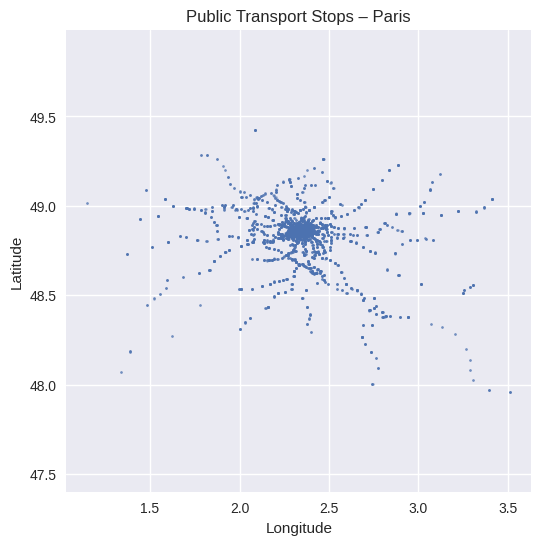

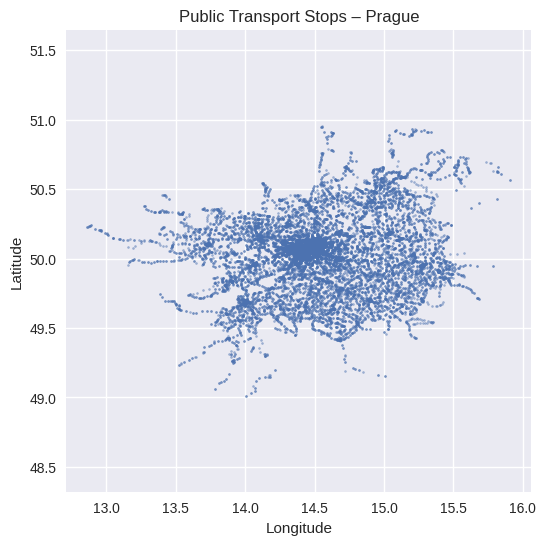

In [ ]:
def plot_stop_scatter(G, city_name="", point_size=2):
    """
    Quick scatter plot of all stops in a GTFS-based graph.
    Uses stop_lon (x) and stop_lat (y) from node attributes.
    """
    lats = []
    lons = []

    for n, data in G.nodes(data=True):
        lat = data.get("stop_lat", None)
        lon = data.get("stop_lon", None)
        if lat is None or lon is None:
            continue

        try:
            lat = float(lat)
            lon = float(lon)
        except ValueError:
            continue

        lats.append(lat)
        lons.append(lon)

    if not lats:
        print(f"No valid coordinates found for {city_name}.")
        return

    plt.figure(figsize=(6, 6))
    plt.scatter(lons, lats, s=point_size, alpha=0.5)
    plt.title(f"Public Transport Stops – {city_name}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


# -----------------------------
# Plot both cities
# -----------------------------
plot_stop_scatter(G_paris,  city_name="Paris",  point_size=2)
plot_stop_scatter(G_prague, city_name="Prague", point_size=2)


# Degree Centrality

## Degree Measures for Paris & Prague

In [ ]:
# --- Helper functions for centrality analysis & visualization ---

def make_centrality_df(G, centrality_dict, measure_name):
    """
    Build a DataFrame from a centrality dict + node attributes.
    """
    rows = []
    for node, data in G.nodes(data=True):
        rows.append({
            "stop_id": node,
            "stop_name": data.get("stop_name"),
            "stop_lat": float(data.get("stop_lat")) if data.get("stop_lat") is not None else np.nan,
            "stop_lon": float(data.get("stop_lon")) if data.get("stop_lon") is not None else np.nan,
            measure_name: centrality_dict.get(node, 0.0)
        })
    df = pd.DataFrame(rows).set_index("stop_id")
    return df


def print_top_n(df, measure_name, city_name, n=5):
    """
    Print top-n stops according to a centrality column.
    """
    print(f"\nTop {n} stops by {measure_name} in {city_name}:")
    top = df.sort_values(measure_name, ascending=False).head(n)
    display(top[["stop_name", measure_name]])


def plot_centrality_hist(df, measure_name, city_name, bins=30):
    """
    Histogram of a centrality measure.
    """
    values = df[measure_name].replace([np.inf, -np.inf], np.nan).dropna()
    plt.figure(figsize=(8, 5))
    plt.hist(values, bins=bins, edgecolor="black", alpha=0.7)
    plt.title(f"{measure_name} distribution – {city_name}")
    plt.xlabel(measure_name)
    plt.ylabel("Number of stops")
    plt.tight_layout()
    plt.show()


def plot_centrality_map(df, measure_name, city_name, point_size=8):
    """
    Simple scatter map of stops colored by a centrality measure.
    """
    df_plot = df.dropna(subset=["stop_lat", "stop_lon", measure_name])
    if df_plot.empty:
        print(f"No data to plot for {city_name} ({measure_name}).")
        return

    plt.figure(figsize=(7, 7))
    sc = plt.scatter(
        df_plot["stop_lon"],
        df_plot["stop_lat"],
        c=df_plot[measure_name],
        s=point_size,
        alpha=0.8
    )
    plt.colorbar(sc, label=measure_name)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"{measure_name} map – {city_name}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


In [ ]:
def compute_degree_measures(G, city_name=""):
    """
    Compute various degree-based measures for a directed PT graph:
      - in-degree, out-degree, total degree
      - in/out degree centrality
      - undirected degree centrality
    Returns a DataFrame indexed by stop_id and also writes the values
    back into the graph as node attributes.
    """

    # ---- Raw degree counts ----
    deg_in = dict(G.in_degree())
    deg_out = dict(G.out_degree())
    deg_total = dict(G.degree())

    # ---- Degree centralities (normalized) ----
    in_deg_centrality = nx.in_degree_centrality(G)
    out_deg_centrality = nx.out_degree_centrality(G)

    # For standard degree_centrality, use an undirected view
    G_und = G.to_undirected()
    deg_centrality_undirected = nx.degree_centrality(G_und)

    # ---- Build DataFrame ----
    rows = []
    for node, data in G.nodes(data=True):
        row = {
            "stop_id": node,
            "stop_name": data.get("stop_name", None),
            "stop_lat": data.get("stop_lat", None),
            "stop_lon": data.get("stop_lon", None),
            "deg_in": deg_in.get(node, 0),
            "deg_out": deg_out.get(node, 0),
            "deg_total": deg_total.get(node, 0),
            "in_deg_centrality": in_deg_centrality.get(node, 0.0),
            "out_deg_centrality": out_deg_centrality.get(node, 0.0),
            "deg_centrality_undirected": deg_centrality_undirected.get(node, 0.0),
        }
        rows.append(row)

    df = pd.DataFrame(rows).set_index("stop_id")

    # ---- Attach as node attributes for later use ----
    nx.set_node_attributes(G, deg_in, name="deg_in")
    nx.set_node_attributes(G, deg_out, name="deg_out")
    nx.set_node_attributes(G, deg_total, name="deg_total")
    nx.set_node_attributes(G, in_deg_centrality, name="in_deg_centrality")
    nx.set_node_attributes(G, out_deg_centrality, name="out_deg_centrality")
    nx.set_node_attributes(G, deg_centrality_undirected, name="deg_centrality_undirected")

    # ---- Basic summary ----
    print(f"\n=== Degree summary for {city_name} ===")
    print(df[["deg_in", "deg_out", "deg_total"]].describe().round(2))

    # Top 10 most connected stops by total degree
    top10 = df.sort_values("deg_total", ascending=False).head(10)
    print(f"\nTop 10 stops by total degree in {city_name}:")
    display(top10[["stop_name", "deg_in", "deg_out", "deg_total"]])

    return df


# -------------------------------------------------
# Compute degree measures for Paris & Prague
# -------------------------------------------------
deg_paris  = compute_degree_measures(G_paris,  city_name="Paris")
deg_prague = compute_degree_measures(G_prague, city_name="Prague")



=== Degree summary for Paris ===
        deg_in  deg_out  deg_total
count  5437.00  5437.00    5437.00
mean      0.40     0.40       0.80
std       1.02     1.02       2.02
min       0.00     0.00       0.00
25%       0.00     0.00       0.00
50%       0.00     0.00       0.00
75%       0.00     0.00       0.00
max      24.00    20.00      44.00

Top 10 stops by total degree in Paris:


,stop_name,deg_in,deg_out,deg_total
stop_id,,,,
IDFM:monomodalStopPlace:462394,Gare du Nord,24,20,44
IDFM:monomodalStopPlace:58566,Gare Saint-Lazare,13,14,27
IDFM:monomodalStopPlace:470195,Gare de Lyon,12,13,25
IDFM:monomodalStopPlace:470549,La Défense,11,11,22
IDFM:monomodalStopPlace:45739,Juvisy,9,10,19
IDFM:monomodalStopPlace:470519,Gare de l'Est,8,9,17
IDFM:monomodalStopPlace:43219,Versailles Chantiers,8,9,17
IDFM:monomodalStopPlace:411428,Chantilly - Gouvieux,8,9,17
IDFM:monomodalStopPlace:43071,Aulnay-sous-Bois,8,8,16



=== Degree summary for Prague ===
         deg_in   deg_out  deg_total
count  18617.00  18617.00   18617.00
mean       1.25      1.25       2.50
std        0.81      0.80       1.42
min        0.00      0.00       0.00
25%        1.00      1.00       2.00
50%        1.00      1.00       2.00
75%        2.00      2.00       3.00
max       11.00      8.00      18.00

Top 10 stops by total degree in Prague:


,stop_name,deg_in,deg_out,deg_total
stop_id,,,,
U3287Z12,"Příbram,aut.nádr. (ul. Čs.armády)",11,7,18
U4830Z1,"Velvary,nám.",8,8,16
U6759Z1,"Vlašim,záv.",10,6,16
U6759Z2,"Vlašim,záv.",8,8,16
U3391Z1,"Mladá Boleslav,Jaselská VZP",11,4,15
U134Z301,Praha-Libeň,7,7,14
U2157Z2,"Uhlířské Janovice,nám.",6,8,14
U4786Z1,"Slaný,Šultysova",7,7,14
U142Z301,Praha hl.n.,7,6,13


In [ ]:
def add_weighted_degree(G, df_deg, city_name=""):
    """
    Compute weighted degree and normalized weighted-degree centrality
    (degree with edge weights = 'weight'), and add them to:
      - the graph node attributes
      - the degree DataFrame (df_deg)
    """
    # raw weighted degree from the DiGraph
    w_deg = dict(G.degree(weight="weight"))
    max_deg = max(w_deg.values()) if w_deg else 1

    w_deg_centrality = {n: d / max_deg for n, d in w_deg.items()}

    # write into graph
    nx.set_node_attributes(G, w_deg, name="weighted_degree")
    nx.set_node_attributes(G, w_deg_centrality, name="weighted_degree_centrality")

    # add to DataFrame
    df_deg = df_deg.copy()
    df_deg["weighted_degree"] = pd.Series(w_deg)
    df_deg["weighted_degree_centrality"] = pd.Series(w_deg_centrality)

    print(f"{city_name}: added weighted_degree and weighted_degree_centrality.")
    return df_deg

deg_paris  = add_weighted_degree(G_paris,  deg_paris,  city_name="Paris")
deg_prague = add_weighted_degree(G_prague, deg_prague, city_name="Prague")


Paris: added weighted_degree and weighted_degree_centrality.
Prague: added weighted_degree and weighted_degree_centrality.


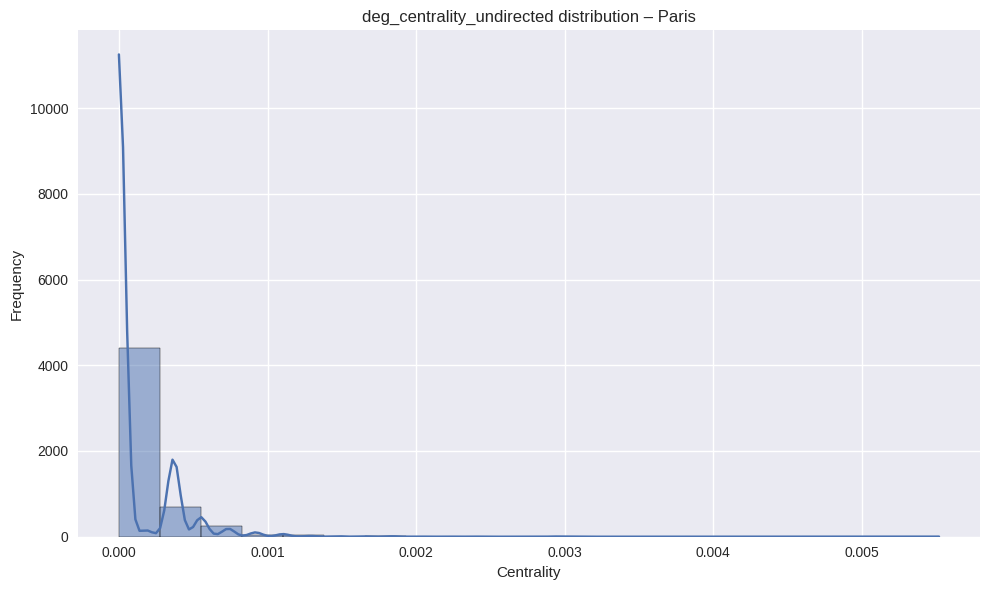

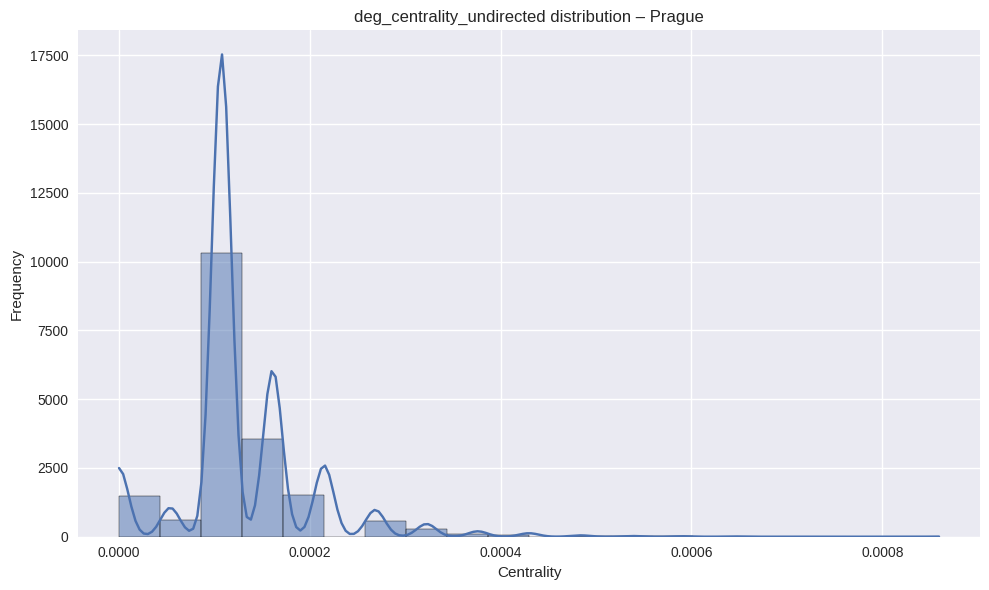

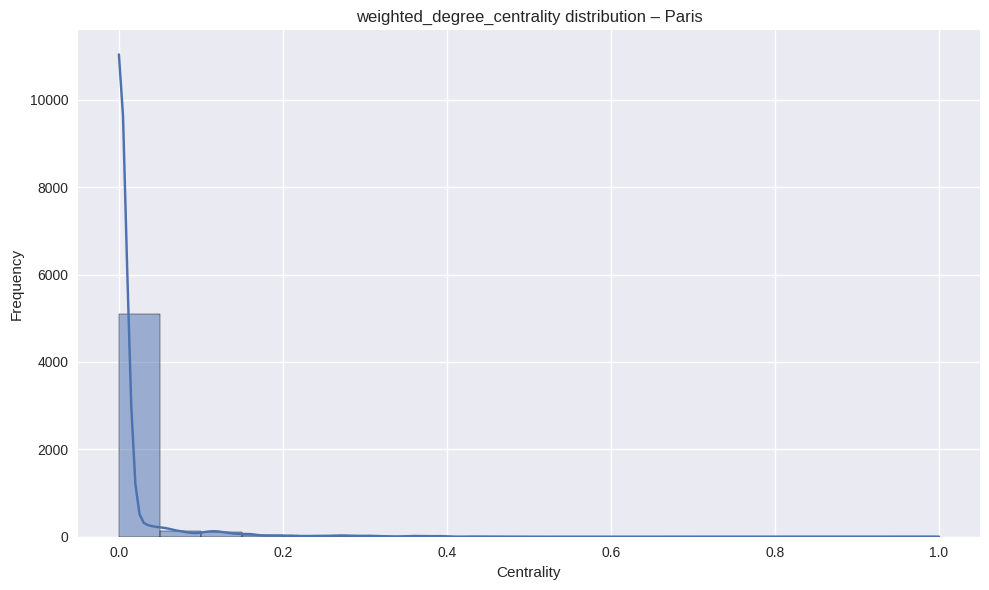

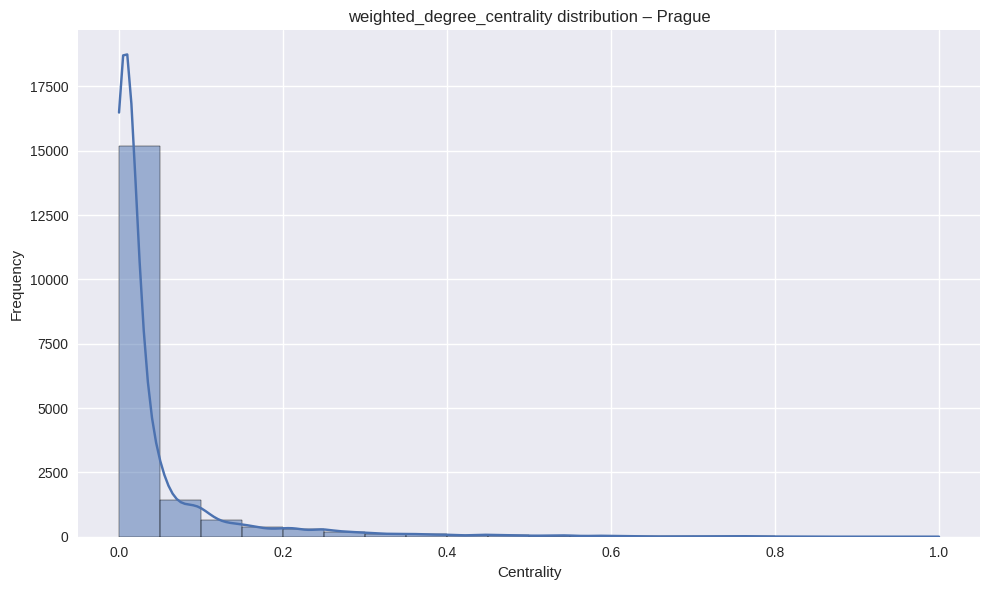

In [ ]:
def plot_degree_centrality_histogram(df, measure, city_name, bins=20):
    values = df[measure].dropna()

    plt.figure(figsize=(10, 6))
    sns.histplot(values, bins=bins, kde=True)
    plt.title(f"{measure} distribution – {city_name}")
    plt.xlabel("Centrality")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# unweighted degree centrality (their "degree")
plot_degree_centrality_histogram(deg_paris,  "deg_centrality_undirected", "Paris")
plot_degree_centrality_histogram(deg_prague, "deg_centrality_undirected", "Prague")

# weighted-degree centrality
plot_degree_centrality_histogram(deg_paris,  "weighted_degree_centrality", "Paris")
plot_degree_centrality_histogram(deg_prague, "weighted_degree_centrality", "Prague")


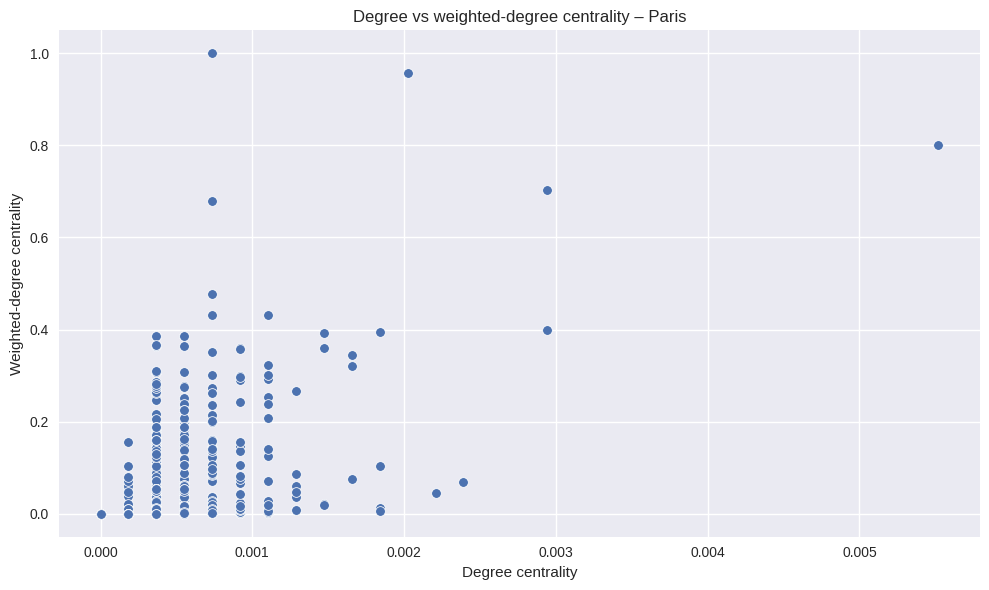

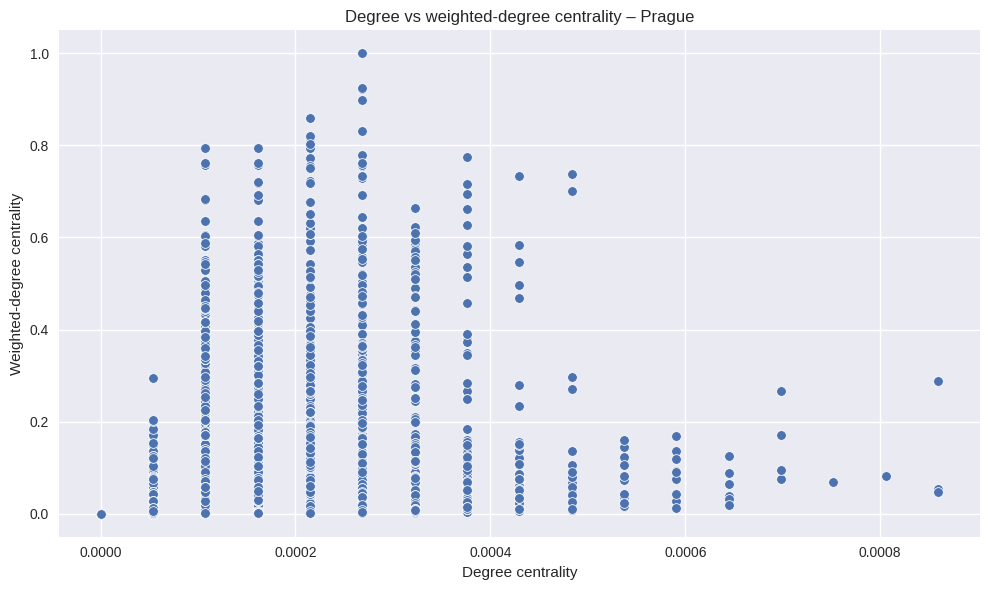

In [ ]:
def plot_degree_vs_weighted(df, city_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df["deg_centrality_undirected"],
        y=df["weighted_degree_centrality"]
    )
    plt.title(f"Degree vs weighted-degree centrality – {city_name}")
    plt.xlabel("Degree centrality")
    plt.ylabel("Weighted-degree centrality")
    plt.tight_layout()
    plt.show()

plot_degree_vs_weighted(deg_paris,  "Paris")
plot_degree_vs_weighted(deg_prague, "Prague")


/tmp/ipython-input-1581023262.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


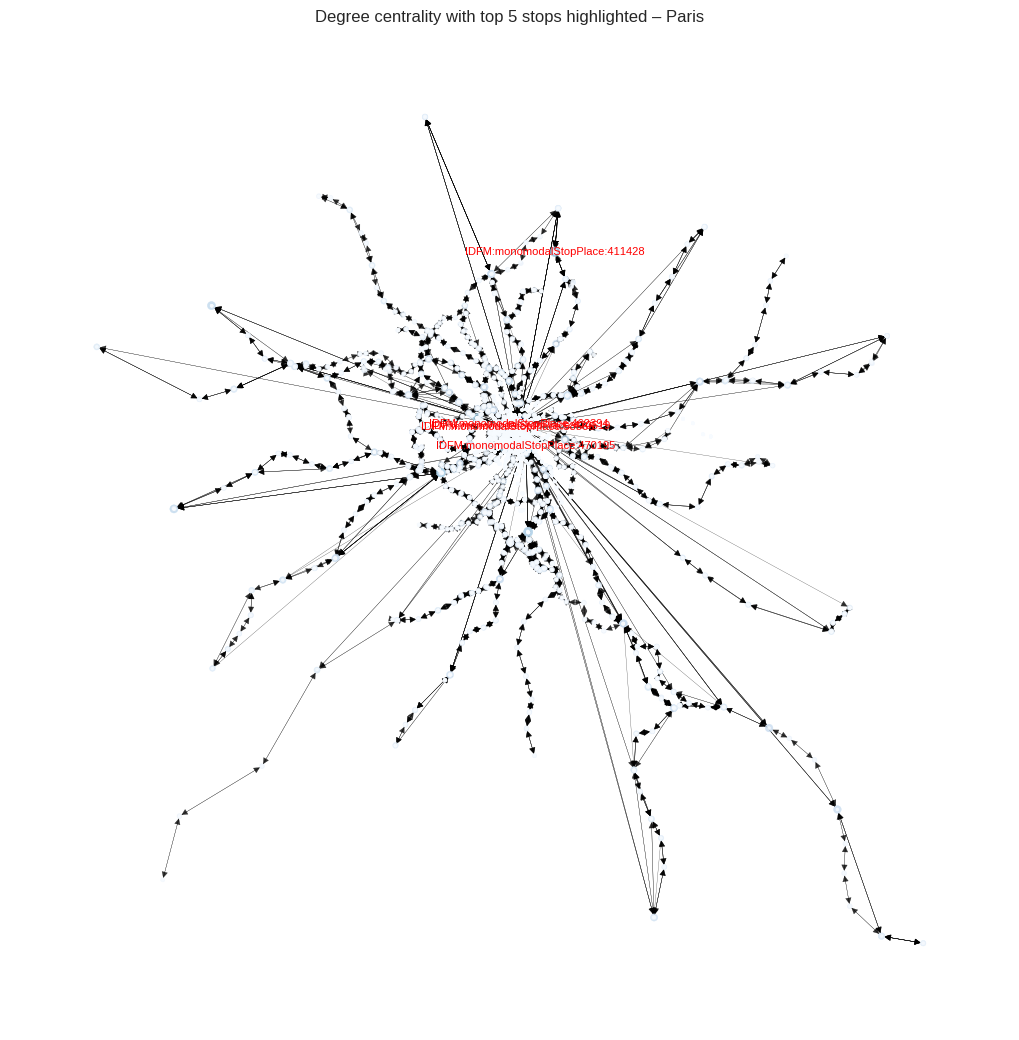

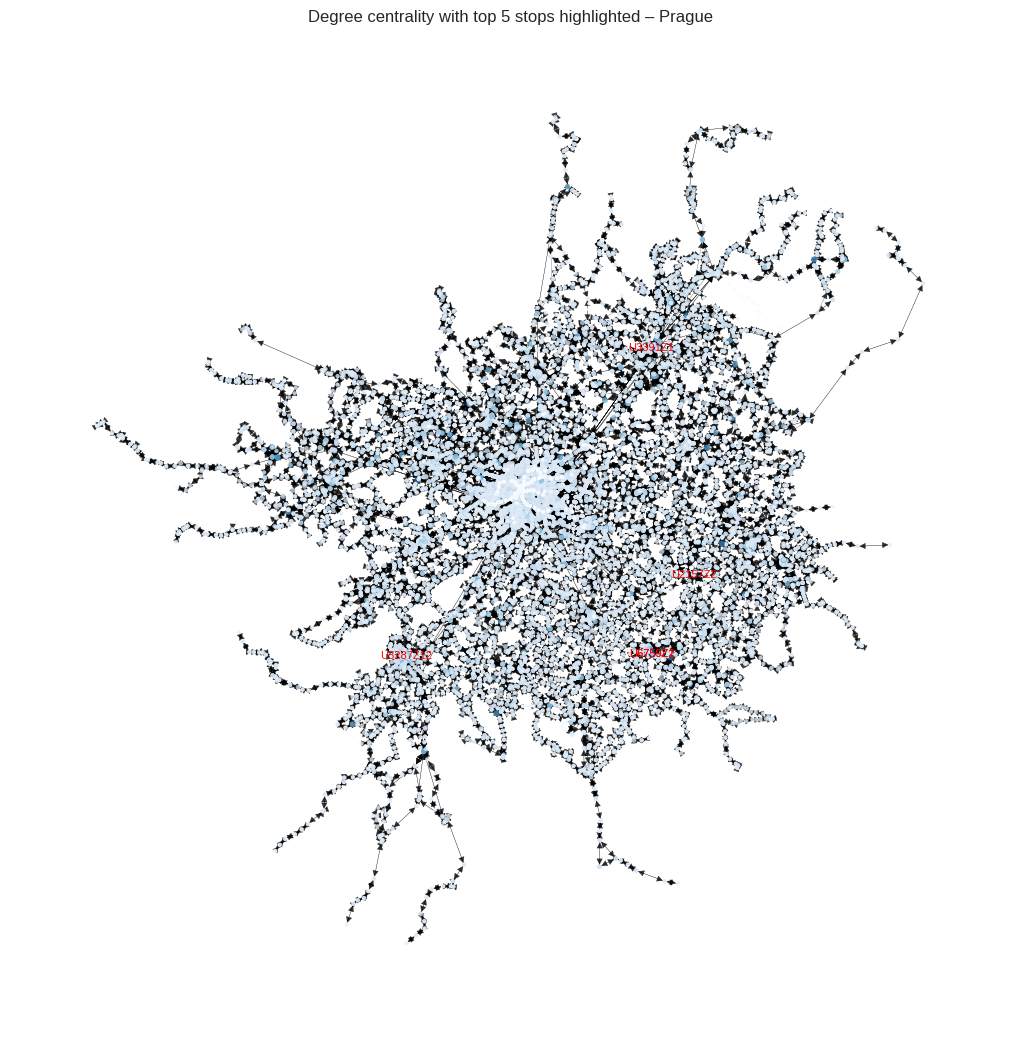

In [ ]:
def plot_network_top_degree(G, df_deg, city_name, top_n=5, figsize=(10, 10)):
    # pick top nodes by degree centrality
    top_nodes = (
        df_deg.sort_values("deg_centrality_undirected", ascending=False)
              .head(top_n)
              .index.tolist()
    )

    # positions from GTFS coordinates (whatever CRS they are in is fine)
    pos = {}
    for n, data in G.nodes(data=True):
        try:
            x = float(data["stop_lon"])
            y = float(data["stop_lat"])
            pos[n] = (x, y)
        except (KeyError, TypeError, ValueError):
            continue

    centrality = {n: G.nodes[n].get("deg_centrality_undirected", 0.0) for n in G.nodes()}

    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos,
        node_size=[centrality[n] * 20000 + 5 for n in G.nodes()],
        node_color=list(centrality.values()),
        cmap=plt.cm.Blues,
        with_labels=False,
        width=0.2,
        alpha=0.8,
    )

    # label only top nodes
    labels = {n: n for n in top_nodes if n in pos}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color="red")

    plt.title(f"Degree centrality with top {top_n} stops highlighted – {city_name}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_network_top_degree(G_paris,  deg_paris,  "Paris",  top_n=5)
plot_network_top_degree(G_prague, deg_prague, "Prague", top_n=5)


In [ ]:
def degree_centrality_map_with_basemap(
    G,
    df_deg,
    centrality_col,
    city_name,
    shapefile_path,
    stops_crs,
    shapefile_crs,
    marker_base_size=5,
):
    """
    Plot degree centrality on a map, with:
      - administrative boundary from a shapefile
      - OpenStreetMap basemap
    """
    # 1. Build GeoDataFrame of stops
    records = []
    for node, data in G.nodes(data=True):
        try:
            lon = float(data["stop_lon"])
            lat = float(data["stop_lat"])
        except (KeyError, TypeError, ValueError):
            continue
        cval = df_deg.loc[node, centrality_col] if node in df_deg.index else 0.0
        records.append({"stop_id": node, "centrality": cval, "geometry": Point(lon, lat)})

    stops_gdf = gpd.GeoDataFrame(records, crs=stops_crs)

    # 2. Read area shapefile
    area_gdf = gpd.read_file(shapefile_path)

    # 3. Reproject both to Web Mercator
    stops_gdf = stops_gdf.to_crs("EPSG:3857")
    area_gdf = area_gdf.to_crs("EPSG:3857")

    # 4. Plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # boundary
    area_gdf.boundary.plot(ax=ax, color="black", linewidth=0.8)

    # centrality points
    centrality_vals = stops_gdf["centrality"].values
    scatter = stops_gdf.plot(
        ax=ax,
        column="centrality",
        cmap="inferno_r",
        markersize=marker_base_size + 5000 * centrality_vals,
        alpha=0.8,
        edgecolor="k",
        legend=True,
    )

    # basemap
    ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{centrality_col} map – {city_name}")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


In [ ]:
# where to store shapefiles
SAVE_DIR = "/content/drive/MyDrive/SNA_Project/shapefiles/"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------------------
# 1. PARIS boundary bounding box
# Approximate bounding box for Paris city (in degrees, WGS84)
# These coordinates cover the entire city and metro area.
# ---------------------------------------
paris_minx, paris_miny = 2.20, 48.80
paris_maxx, paris_maxy = 2.48, 48.92

paris_poly = box(paris_minx, paris_miny, paris_maxx, paris_maxy)

paris_gdf = gpd.GeoDataFrame(
    {"name": ["Paris"]},
    geometry=[paris_poly],
    crs="EPSG:4326"
)

paris_path = os.path.join(SAVE_DIR, "paris_boundary.shp")
paris_gdf.to_file(paris_path)
print("✓ Paris boundary shapefile saved to:", paris_path)

# ---------------------------------------
# 2. PRAGUE boundary bounding box
# Covers Prague + metro region.
# ---------------------------------------
prague_minx, prague_miny = 14.20, 49.95
prague_maxx, prague_maxy = 14.70, 50.20

prague_poly = box(prague_minx, prague_miny, prague_maxx, prague_maxy)

prague_gdf = gpd.GeoDataFrame(
    {"name": ["Prague"]},
    geometry=[prague_poly],
    crs="EPSG:4326"
)

prague_path = os.path.join(SAVE_DIR, "prague_boundary.shp")
prague_gdf.to_file(prague_path)
print("✓ Prague boundary shapefile saved to:", prague_path)


✓ Paris boundary shapefile saved to: /content/drive/MyDrive/SNA_Project/shapefiles/paris_boundary.shp
✓ Prague boundary shapefile saved to: /content/drive/MyDrive/SNA_Project/shapefiles/prague_boundary.shp


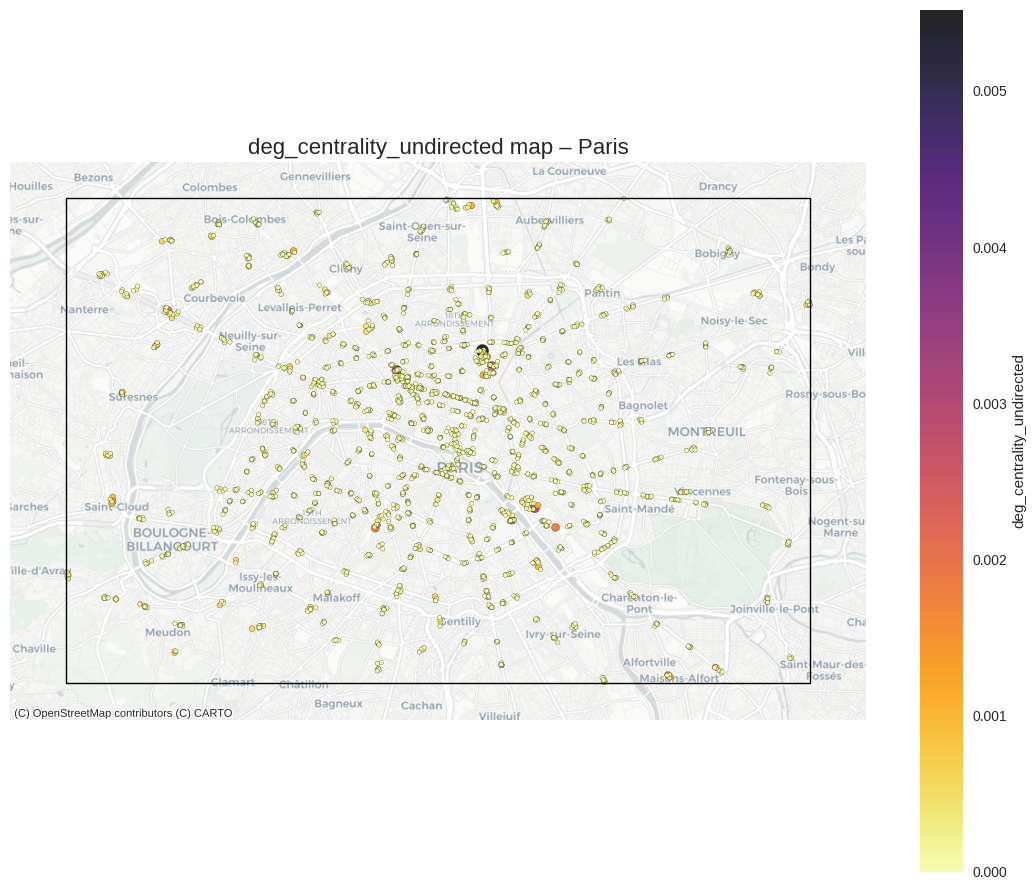

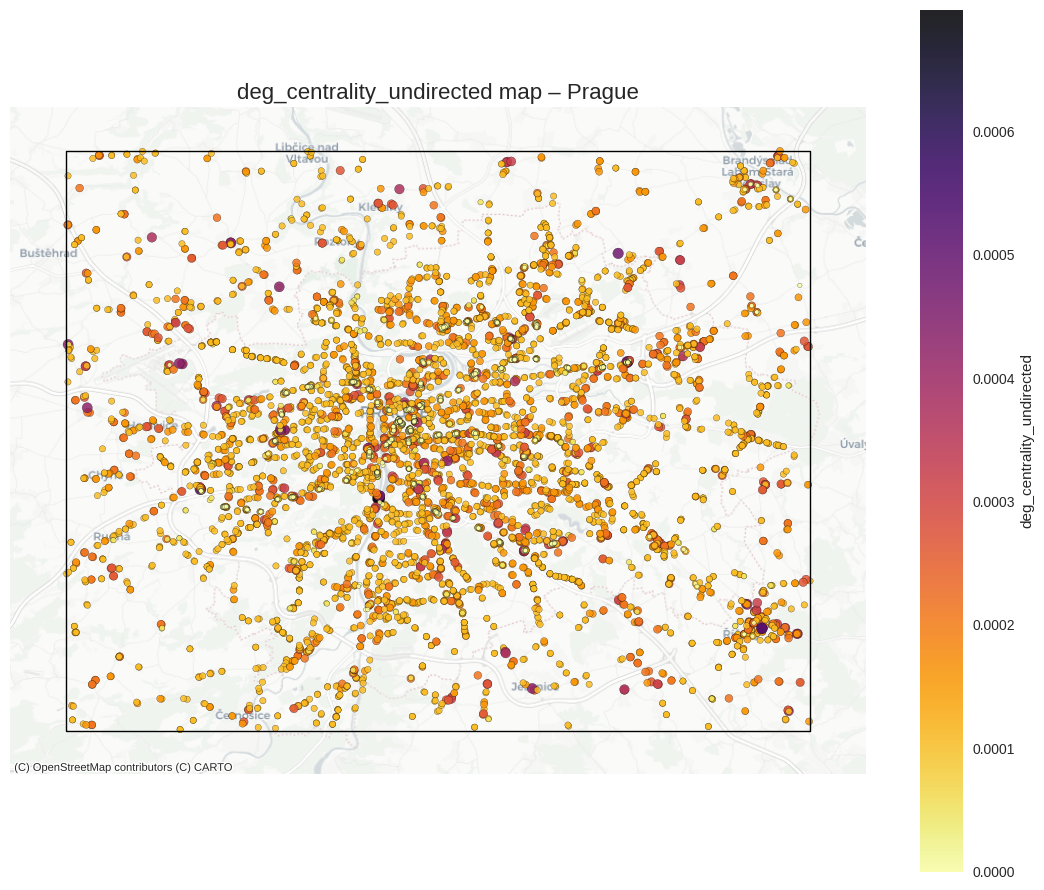

In [ ]:
# ============================================
# DEGREE CENTRALITY MAPS with BASEMAP + ZOOM-OUT
# ============================================

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import numpy as np
import os

def degree_centrality_map_with_basemap(
    G,
    df_deg,
    centrality_col,
    city_name,
    shapefile_path,
    stops_crs="EPSG:4326",
    shapefile_crs="EPSG:4326",
    min_size=10,
    max_size=80,
    cmap="inferno_r",
    zoom_out_factor=1.15,   # <--- change this if you want more/less zoom
):
    """
    Plot a degree-centrality map for a city:
      - nodes sized & colored by centrality_col
      - clipped to city boundary from shapefile_path
      - zoomed slightly out around that boundary
      - contextily basemap as background
    """

    # ---------- 1. Build GeoDataFrame for stops ----------
    records = []
    for node, data in G.nodes(data=True):
        try:
            lon = float(data["stop_lon"])
            lat = float(data["stop_lat"])
        except (KeyError, TypeError, ValueError):
            continue

        cval = df_deg.loc[node, centrality_col] if node in df_deg.index else 0.0
        records.append(
            {"stop_id": node, "centrality": cval, "geometry": Point(lon, lat)}
        )

    if not records:
        print(f"No valid stop coordinates for {city_name}.")
        return

    stops_gdf = gpd.GeoDataFrame(records, crs=stops_crs)

    # ---------- 2. Read shapefile ----------
    if not os.path.exists(shapefile_path):
        raise FileNotFoundError(f"Shapefile not found: {shapefile_path}")

    area_gdf = gpd.read_file(shapefile_path)

    if area_gdf.crs is None:
        area_gdf.set_crs(shapefile_crs, inplace=True)
    elif area_gdf.crs.to_string() != shapefile_crs:
        area_gdf = area_gdf.to_crs(shapefile_crs)

    # ---------- 3. Reproject to Web Mercator ----------
    stops_gdf = stops_gdf.to_crs("EPSG:3857")
    area_gdf = area_gdf.to_crs("EPSG:3857")

    # Optional: keep only stops inside boundary (cleaner)
    area_union = area_gdf.union_all()
    stops_gdf = stops_gdf[stops_gdf.within(area_union)]

    # ---------- 4. Prepare sizes & colors ----------
    cvals = stops_gdf["centrality"].values
    if np.isfinite(cvals).any():
        c_min = cvals.min()
        c_max = cvals.max()
        if c_max > c_min:
            norm_c = (cvals - c_min) / (c_max - c_min)
        else:
            norm_c = np.zeros_like(cvals)
    else:
        norm_c = np.zeros_like(cvals)

    sizes = min_size + norm_c * (max_size - min_size)

    # ---------- 5. Plot ----------
    fig, ax = plt.subplots(figsize=(11, 9))

    # boundary outline
    area_gdf.boundary.plot(ax=ax, color="black", linewidth=1.0)

    sc = ax.scatter(
        stops_gdf.geometry.x,
        stops_gdf.geometry.y,
        c=cvals,
        s=sizes,
        cmap=cmap,
        alpha=0.85,
        edgecolors="black",
        linewidths=0.2,
    )

    # ---------- 6. Zoom to boundary + slight zoom-out ----------
    xmin, ymin, xmax, ymax = area_gdf.total_bounds

    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2

    x_half_range = (xmax - xmin) * zoom_out_factor / 2
    y_half_range = (ymax - ymin) * zoom_out_factor / 2

    ax.set_xlim(x_center - x_half_range, x_center + x_half_range)
    ax.set_ylim(y_center - y_half_range, y_center + y_half_range)

    # ---------- 7. Basemap ----------
    ctx.add_basemap(
        ax,
        crs="EPSG:3857",
        source=ctx.providers.CartoDB.Positron
    )

    # ---------- 8. Colorbar & title ----------
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(centrality_col)

    ax.set_title(f"{centrality_col} map – {city_name}", fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# --------------------------------------------
# CALL FOR PARIS & PRAGUE
# --------------------------------------------

PARIS_SHAPEFILE_PATH  = "/content/drive/MyDrive/SNA_Project/shapefiles/paris_boundary.shp"
PRAGUE_SHAPEFILE_PATH = "/content/drive/MyDrive/SNA_Project/shapefiles/prague_boundary.shp"

STOPS_CRS_PARIS      = "EPSG:4326"
STOPS_CRS_PRAGUE     = "EPSG:4326"
SHAPEFILE_CRS_PARIS  = "EPSG:4326"
SHAPEFILE_CRS_PRAGUE = "EPSG:4326"

degree_centrality_map_with_basemap(
    G_paris,
    deg_paris,
    centrality_col="deg_centrality_undirected",
    city_name="Paris",
    shapefile_path=PARIS_SHAPEFILE_PATH,
    stops_crs=STOPS_CRS_PARIS,
    shapefile_crs=SHAPEFILE_CRS_PARIS,
    zoom_out_factor=1.15,  # tweak if you want more/less zoom
)

degree_centrality_map_with_basemap(
    G_prague,
    deg_prague,
    centrality_col="deg_centrality_undirected",
    city_name="Prague",
    shapefile_path=PRAGUE_SHAPEFILE_PATH,
    stops_crs=STOPS_CRS_PRAGUE,
    shapefile_crs=SHAPEFILE_CRS_PRAGUE,
    zoom_out_factor=1.15,
)


In [ ]:
"""
# Global Efficiency Analysis

Global efficiency measures how efficiently information (or passengers) can travel through the network.
It's calculated as the average of the inverse shortest path lengths between all pairs of nodes.
"""

def calculate_global_efficiency(G, sample_size=None):
    """
    Calculate global efficiency of a graph.

    Global efficiency = average of (1/shortest_path_length) for all node pairs

    Parameters:
    -----------
    G : networkx.Graph
        Input graph (can be directed or undirected)
    sample_size : int, optional
        If provided, sample this many nodes for efficiency calculation
        (useful for large graphs)

    Returns:
    --------
    float : Global efficiency value (0 to 1)
    """
    # Get largest connected component for meaningful analysis
    if G.is_directed():
        # For directed graphs, use weakly connected components
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)

    G_cc = G.subgraph(largest_cc).copy()

    print(f"Analyzing largest connected component: {len(G_cc.nodes())} nodes")

    # Sample nodes if graph is too large
    if sample_size and len(G_cc.nodes()) > sample_size:
        nodes = np.random.choice(list(G_cc.nodes()), size=sample_size, replace=False)
        print(f"Sampling {sample_size} nodes for efficiency calculation")
    else:
        nodes = list(G_cc.nodes())

    # Calculate efficiency
    total_efficiency = 0
    count = 0

    for i, source in enumerate(tqdm(nodes, desc="Calculating efficiency")):
        # Get shortest paths from source to all other nodes
        try:
            if G.is_directed():
                lengths = nx.single_source_shortest_path_length(G_cc, source)
            else:
                lengths = nx.single_source_shortest_path_length(G_cc, source)

            for target, length in lengths.items():
                if source != target and length > 0:
                    total_efficiency += 1.0 / length
                    count += 1
        except:
            continue

    if count == 0:
        return 0.0

    # Normalize by number of pairs
    n = len(nodes)
    global_efficiency = total_efficiency / (n * (n - 1))

    return global_efficiency


def calculate_local_efficiency(G, sample_size=None):
    """
    Calculate local efficiency of a graph.

    Local efficiency measures how well the neighbors of a node
    are connected to each other.

    Parameters:
    -----------
    G : networkx.Graph
        Input graph
    sample_size : int, optional
        If provided, sample this many nodes

    Returns:
    --------
    float : Average local efficiency
    """
    if sample_size and len(G.nodes()) > sample_size:
        nodes = np.random.choice(list(G.nodes()), size=sample_size, replace=False)
    else:
        nodes = list(G.nodes())

    local_efficiencies = []

    for node in tqdm(nodes, desc="Calculating local efficiency"):
        neighbors = list(G.neighbors(node))

        if len(neighbors) < 2:
            continue

        # Create subgraph of neighbors
        subgraph = G.subgraph(neighbors)

        # Calculate efficiency of this subgraph
        if len(subgraph.nodes()) > 1:
            try:
                local_eff = nx.global_efficiency(subgraph)
                local_efficiencies.append(local_eff)
            except:
                continue

    if not local_efficiencies:
        return 0.0

    return np.mean(local_efficiencies)

In [23]:
# Calculate Efficiency for Paris
# ============================================================================
print("\n" + "="*60)
print("PARIS - Global Efficiency Analysis")
print("="*60)

# Use sampling for large graphs
paris_global_eff = calculate_global_efficiency(G_paris, sample_size=None)
print(f"\nParis Global Efficiency: {paris_global_eff:.4f}")

# Calculate Local Efficiency
paris_local_eff = calculate_local_efficiency(G_paris, sample_size=None)
print(f"Paris Local Efficiency: {paris_local_eff:.4f}")


PARIS - Global Efficiency Analysis
Analyzing largest connected component: 577 nodes


Calculating efficiency: 100%|██████████| 577/577 [00:00<00:00, 3605.91it/s]



Paris Global Efficiency: 0.1044


Calculating local efficiency: 100%|██████████| 5437/5437 [00:00<00:00, 342949.56it/s]

Paris Local Efficiency: 0.0000


In [24]:
# Calculate Efficiency for Prague
# ============================================================================
print("\n" + "="*60)
print("PRAGUE - Global Efficiency Analysis")
print("="*60)

prague_global_eff = calculate_global_efficiency(G_prague, sample_size=None)
print(f"\nPrague Global Efficiency: {prague_global_eff:.4f}")

prague_local_eff = calculate_local_efficiency(G_prague, sample_size=None)
print(f"Prague Local Efficiency: {prague_local_eff:.4f}")


PRAGUE - Global Efficiency Analysis
Analyzing largest connected component: 16152 nodes


Calculating efficiency: 100%|██████████| 16152/16152 [02:05<00:00, 129.00it/s]



Prague Global Efficiency: 0.0128


Calculating local efficiency: 100%|██████████| 18617/18617 [00:00<00:00, 302406.76it/s]

Prague Local Efficiency: 0.0000


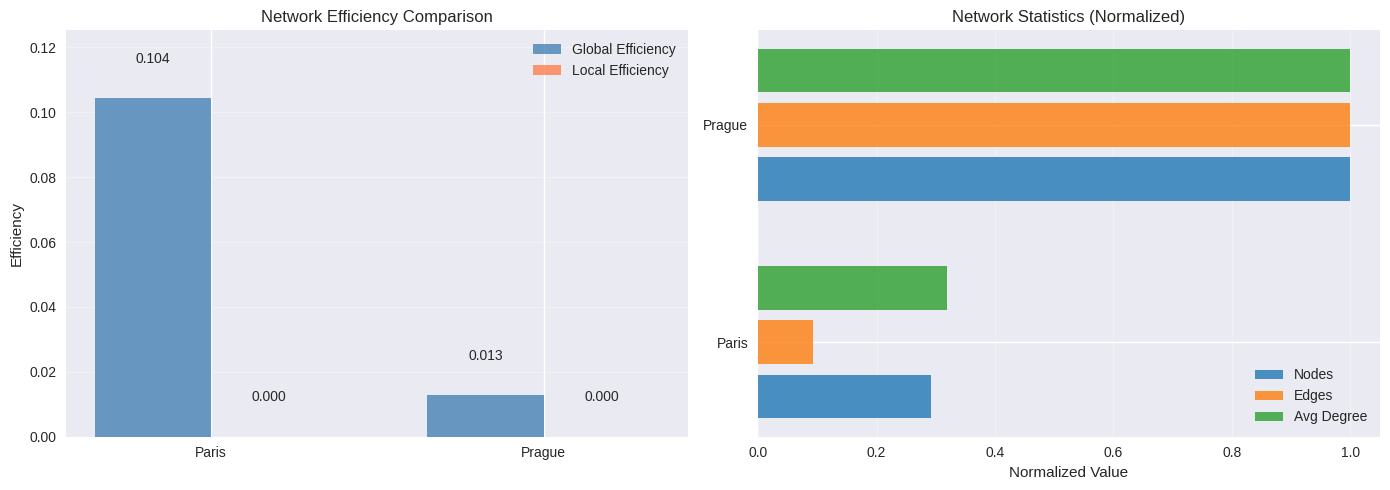

In [25]:
# Comparative Visualization
# ============================================================================
# Comparative Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Global Efficiency Comparison
cities = ['Paris', 'Prague']
global_effs = [paris_global_eff, prague_global_eff]
local_effs = [paris_local_eff, prague_local_eff]

x = np.arange(len(cities))
width = 0.35

axes[0].bar(x - width/2, global_effs, width, label='Global Efficiency', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, local_effs, width, label='Local Efficiency', color='coral', alpha=0.8)
axes[0].set_ylabel('Efficiency')
axes[0].set_title('Network Efficiency Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(cities)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, max(max(global_effs), max(local_effs)) * 1.2)

# Add value labels on bars
for i, (g, l) in enumerate(zip(global_effs, local_effs)):
    axes[0].text(i - width/2, g + 0.01, f'{g:.3f}', ha='center', va='bottom', fontsize=10)
    axes[0].text(i + width/2, l + 0.01, f'{l:.3f}', ha='center', va='bottom', fontsize=10)

# Network Statistics Comparison
stats_data = {
    'Nodes': [G_paris.number_of_nodes(), G_prague.number_of_nodes()],
    'Edges': [G_paris.number_of_edges(), G_prague.number_of_edges()],
    'Avg Degree': [
        sum(dict(G_paris.degree()).values()) / G_paris.number_of_nodes(),
        sum(dict(G_prague.degree()).values()) / G_prague.number_of_nodes()
    ]
}

x_pos = np.arange(len(cities))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (stat_name, values) in enumerate(stats_data.items()):
    normalized_values = [v / max(values) for v in values]
    axes[1].barh([i + idx*0.25 for i in x_pos], normalized_values,
                 height=0.2, label=stat_name, color=colors[idx], alpha=0.8)

axes[1].set_yticks([i + 0.25 for i in x_pos])
axes[1].set_yticklabels(cities)
axes[1].set_xlabel('Normalized Value')
axes[1].set_title('Network Statistics (Normalized)')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
# Detailed Analysis Summary
# ============================================================================
print("\n" + "="*70)
print("COMPREHENSIVE NETWORK EFFICIENCY ANALYSIS")
print("="*70)

summary_data = {
    'Metric': [
        'Total Stops (Nodes)',
        'Total Connections (Edges)',
        'Average Degree',
        'Global Efficiency',
        'Local Efficiency',
        'Density',
        'Weakly Connected Components'
    ],
    'Paris': [
        G_paris.number_of_nodes(),
        G_paris.number_of_edges(),
        f"{sum(dict(G_paris.degree()).values()) / G_paris.number_of_nodes():.2f}",
        f"{paris_global_eff:.4f}",
        f"{paris_local_eff:.4f}",
        f"{nx.density(G_paris):.4f}",
        nx.number_weakly_connected_components(G_paris)
    ],
    'Prague': [
        G_prague.number_of_nodes(),
        G_prague.number_of_edges(),
        f"{sum(dict(G_prague.degree()).values()) / G_prague.number_of_nodes():.2f}",
        f"{prague_global_eff:.4f}",
        f"{prague_local_eff:.4f}",
        f"{nx.density(G_prague):.4f}",
        nx.number_weakly_connected_components(G_prague)
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("""
Global Efficiency (0-1):
  - Measures how efficiently passengers can travel between any two stops
  - Higher values indicate better overall connectivity
  - Values closer to 1 mean shorter average path lengths

Local Efficiency (0-1):
  - Measures how well-connected the neighbors of each stop are
  - Higher values indicate better fault tolerance (alternative routes)
  - Important for network resilience

Network Density:
  - Ratio of actual connections to possible connections
  - Higher density = more direct connections between stops
""")

# Determine which city has better efficiency
if paris_global_eff > prague_global_eff:
    better_city = "Paris"
    diff = ((paris_global_eff - prague_global_eff) / prague_global_eff) * 100
else:
    better_city = "Prague"
    diff = ((prague_global_eff - paris_global_eff) / paris_global_eff) * 100

print(f"\n{better_city} has {diff:.1f}% higher global efficiency.")
print(f"\nThis suggests that {better_city}'s public transport network allows for")
print("more efficient travel between stops on average.")


COMPREHENSIVE NETWORK EFFICIENCY ANALYSIS

                      Metric  Paris Prague
        Total Stops (Nodes)   5437  18617
  Total Connections (Edges)   2169  23306
             Average Degree   0.80   2.50
          Global Efficiency 0.1044 0.0128
           Local Efficiency 0.0000 0.0000
                    Density 0.0001 0.0001
Weakly Connected Components   4345   1482

INTERPRETATION

Global Efficiency (0-1):
  - Measures how efficiently passengers can travel between any two stops
  - Higher values indicate better overall connectivity
  - Values closer to 1 mean shorter average path lengths

Local Efficiency (0-1):
  - Measures how well-connected the neighbors of each stop are
  - Higher values indicate better fault tolerance (alternative routes)
  - Important for network resilience

Network Density:
  - Ratio of actual connections to possible connections
  - Higher density = more direct connections between stops


Paris has 714.4% higher global efficiency.

This suggests tha

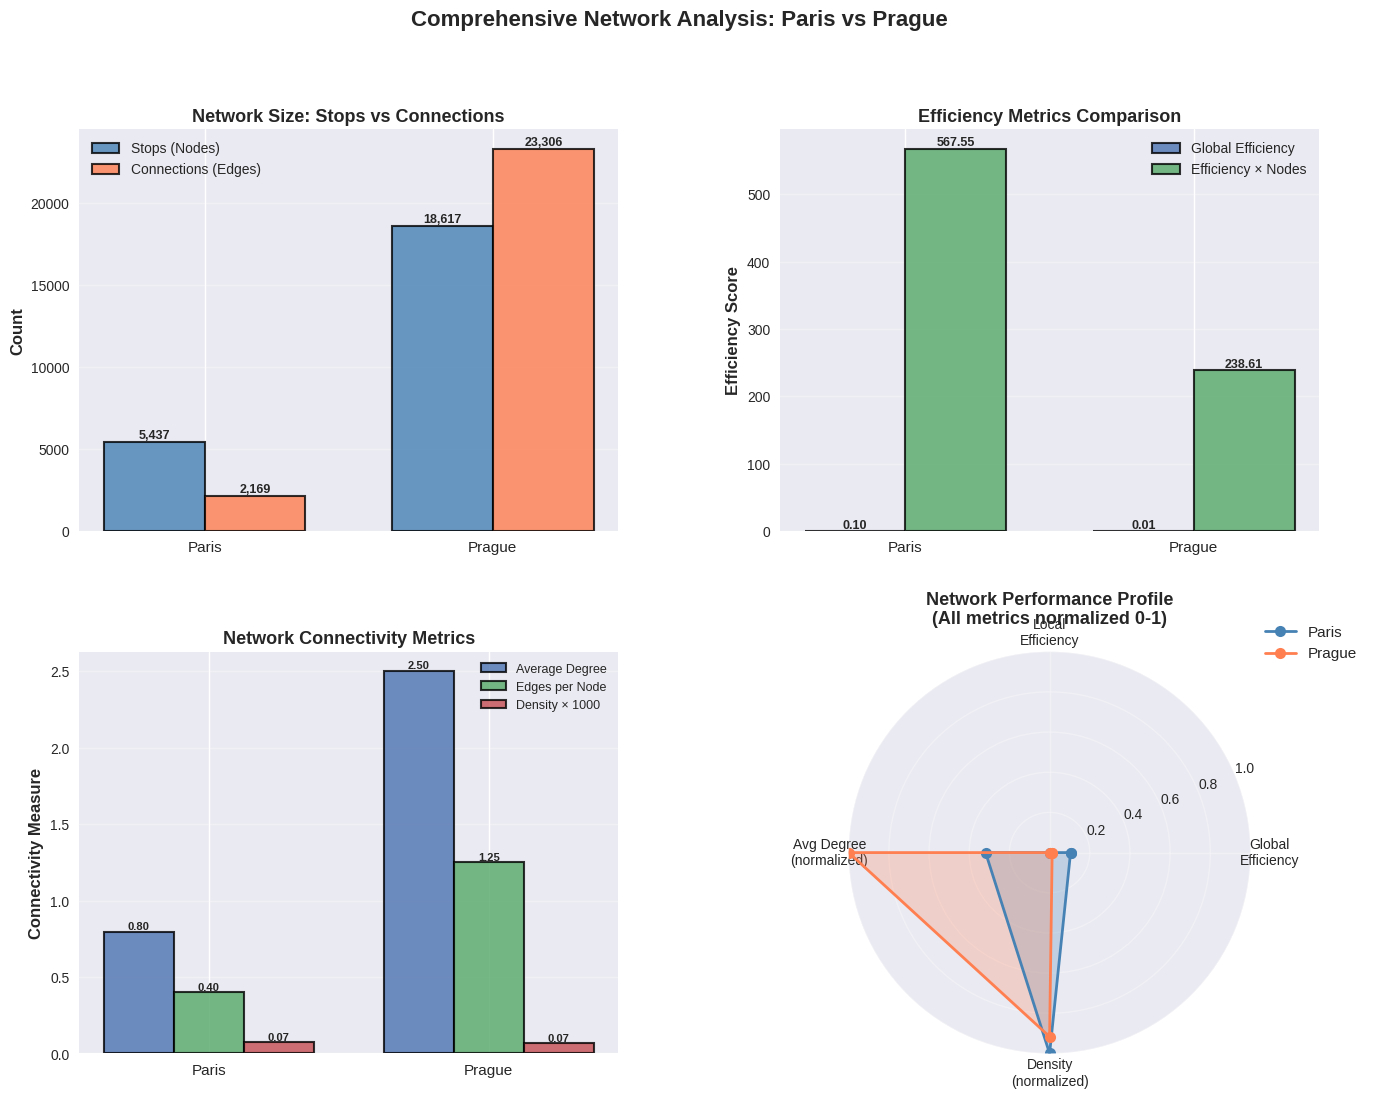


CHART INTERPRETATION

Chart 1 (Top Left) - Network Size:
  Shows the raw size difference between networks
  Prague has ~3.4x more stops and ~10.7x more connections than Paris

Chart 2 (Top Right) - Efficiency Metrics:
  Compares pure efficiency vs scaled efficiency
  Higher values = better network performance

Chart 3 (Bottom Left) - Connectivity:
  Average Degree: How many connections each stop has on average
  Edges per Node: Connection density
  Density: How interconnected the network is

Chart 4 (Bottom Right) - Performance Profile:
  Radar chart showing all metrics normalized to 0-1
  Larger area = better overall network performance
  Shows which city excels in which aspect



In [31]:
# CELL 6: Additional Visualizations - Network Characteristics
# ============================================================================

# Create a 2x2 grid of visualizations
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

cities_list = ['Paris', 'Prague']
colors_map = ['steelblue', 'coral']

# ---- Chart 1: Network Size Comparison ----
ax1 = fig.add_subplot(gs[0, 0])
nodes_count = [G_paris.number_of_nodes(), G_prague.number_of_nodes()]
edges_count = [G_paris.number_of_edges(), G_prague.number_of_edges()]

x = np.arange(len(cities_list))
width = 0.35

bars1 = ax1.bar(x - width/2, nodes_count, width, label='Stops (Nodes)',
                color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, edges_count, width, label='Connections (Edges)',
                color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Network Size: Stops vs Connections', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(cities_list, fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# ---- Chart 2: Efficiency per Stop (Normalized) ----
ax2 = fig.add_subplot(gs[0, 1])

# Calculate efficiency per stop (how efficient is each stop on average)
eff_per_stop_paris = paris_global_eff * G_paris.number_of_nodes()
eff_per_stop_prague = prague_global_eff * G_prague.number_of_nodes()

efficiency_metrics = {
    'Global Efficiency': [paris_global_eff, prague_global_eff],
    'Efficiency × Nodes': [eff_per_stop_paris, eff_per_stop_prague]
}

x = np.arange(len(cities_list))
width = 0.35
multiplier = 0

for attribute, measurement in efficiency_metrics.items():
    offset = width * multiplier
    bars = ax2.bar(x + offset, measurement, width, label=attribute,
                   alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    multiplier += 1

ax2.set_ylabel('Efficiency Score', fontsize=12, fontweight='bold')
ax2.set_title('Efficiency Metrics Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x + width / 2)
ax2.set_xticklabels(cities_list, fontsize=11)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# ---- Chart 3: Connectivity Ratio ----
ax3 = fig.add_subplot(gs[1, 0])

# Calculate various connectivity metrics
avg_degree_paris = sum(dict(G_paris.degree()).values()) / G_paris.number_of_nodes()
avg_degree_prague = sum(dict(G_prague.degree()).values()) / G_prague.number_of_nodes()

edges_per_node_paris = G_paris.number_of_edges() / G_paris.number_of_nodes()
edges_per_node_prague = G_prague.number_of_edges() / G_prague.number_of_nodes()

connectivity_data = {
    'Average Degree': [avg_degree_paris, avg_degree_prague],
    'Edges per Node': [edges_per_node_paris, edges_per_node_prague],
    'Density × 1000': [nx.density(G_paris) * 1000, nx.density(G_prague) * 1000]
}

x = np.arange(len(cities_list))
width = 0.25
multiplier = 0

for attribute, measurement in connectivity_data.items():
    offset = width * multiplier
    bars = ax3.bar(x + offset, measurement, width, label=attribute,
                   alpha=0.8, edgecolor='black', linewidth=1.5)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

    multiplier += 1

ax3.set_ylabel('Connectivity Measure', fontsize=12, fontweight='bold')
ax3.set_title('Network Connectivity Metrics', fontsize=13, fontweight='bold')
ax3.set_xticks(x + width)
ax3.set_xticklabels(cities_list, fontsize=11)
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# ---- Chart 4: Efficiency Breakdown (Radar/Spider Chart) ----
ax4 = fig.add_subplot(gs[1, 1], projection='polar')

# Normalize all metrics to 0-1 scale for comparison
metrics = {
    'Global\nEfficiency': [paris_global_eff, prague_global_eff],
    'Local\nEfficiency': [paris_local_eff, prague_local_eff],
    'Avg Degree\n(normalized)': [
        avg_degree_paris / max(avg_degree_paris, avg_degree_prague),
        avg_degree_prague / max(avg_degree_paris, avg_degree_prague)
    ],
    'Density\n(normalized)': [
        nx.density(G_paris) / max(nx.density(G_paris), nx.density(G_prague)),
        nx.density(G_prague) / max(nx.density(G_paris), nx.density(G_prague))
    ]
}

categories = list(metrics.keys())
N = len(categories)

# Compute angle for each axis
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Plot data
for idx, city in enumerate(cities_list):
    values = [metrics[cat][idx] for cat in categories]
    values += values[:1]

    ax4.plot(angles, values, 'o-', linewidth=2, label=city,
             color=colors_map[idx], markersize=8)
    ax4.fill(angles, values, alpha=0.25, color=colors_map[idx])

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories, fontsize=10)
ax4.set_ylim(0, 1)
ax4.set_title('Network Performance Profile\n(All metrics normalized 0-1)',
              fontsize=13, fontweight='bold', pad=20)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Network Analysis: Paris vs Prague',
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

# Print interpretation
print("\n" + "="*70)
print("CHART INTERPRETATION")
print("="*70)
print("""
Chart 1 (Top Left) - Network Size:
  Shows the raw size difference between networks
  Prague has ~3.4x more stops and ~10.7x more connections than Paris

Chart 2 (Top Right) - Efficiency Metrics:
  Compares pure efficiency vs scaled efficiency
  Higher values = better network performance

Chart 3 (Bottom Left) - Connectivity:
  Average Degree: How many connections each stop has on average
  Edges per Node: Connection density
  Density: How interconnected the network is

Chart 4 (Bottom Right) - Performance Profile:
  Radar chart showing all metrics normalized to 0-1
  Larger area = better overall network performance
  Shows which city excels in which aspect
""")
